# Basic Instructions

1. Enter your Name, UID and Link to Google Drive in the provided space.
2. Submit the assignment to Gradescope.

Intermediate Submission Deadline: April 13, 5:00pm

Final Submission Deadline: April 16, 5:00pm

As before, submit your challenge file to ELMS.

Name:  **Pooja Kabra**  
UID:  **117032444**

Link to Google Drive : **https://colab.research.google.com/drive/1tggfzDcADhaqIa_SJNFjjSdDxwUJmgb4?usp=sharing**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

## Dataset and Preprocessing

For this assignment, we will use the following dataset, which contains images of animals and such with segmentations.

In [3]:
#For deleting the dataset
#!rm -r SegmentationDataset/

In [4]:
#Use this to download if not using colab
#download_link='https://drive.google.com/file/d/1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn/view?usp=sharing'

#If using colab dataset can be downloaded using this command
!gdown --id 1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn
!unzip --qq SegmentationDataset.zip

Downloading...
From: https://drive.google.com/uc?id=1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn
To: /content/SegmentationDataset.zip
44.1MB [00:00, 138MB/s] 


In [5]:

%matplotlib inline
import cv2
import os
import torch.utils.data as data
from torchvision import transforms
import _pickle as pickle
import torchvision.models as models
import glob

current_directory = os.getcwd()
msrc_directory = current_directory + '/SegmentationDataset'

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """

    plt.figure()
    if(im.shape[2]==1):
        plt.imshow(np.squeeze(im),cmap='gray')
    elif cv2:
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)
    

In [6]:
# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

background_classes=["void","grass","sky"]
background_colors=[]
for i in range(len(SEG_LABELS_LIST_v1)):
    if SEG_LABELS_LIST_v1[i]["name"] in background_classes:
        background_colors.append(SEG_LABELS_LIST_v1[i]["rgb_values"])



def get_binary_seg(bgr_seg):
    rgb_seg=bgr_seg#[:,:,::-1]#reverse order of channels from bgr to rgb
    shape_rgb=rgb_seg.shape
    binary_shape=(shape_rgb[0],shape_rgb[1],1)

    binary_map=np.ones( binary_shape )  
    for background_color in background_colors:
        binary_map[(rgb_seg==background_color).all(2)]=0
    
    return binary_map

Here are some examples.

<class 'numpy.ndarray'>
(213, 320, 3)


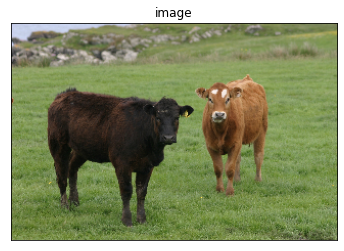

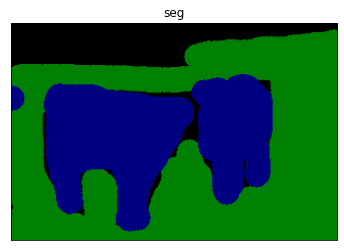

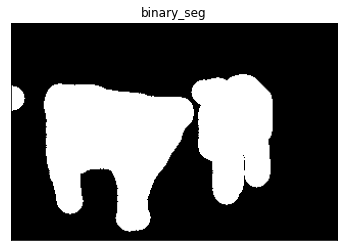

In [7]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('SegmentationDataset/train/1_19_s.bmp')
seg_sample = cv2.imread('SegmentationDataset/train/1_19_s_GT.bmp') 
print(type(seg_sample))
print(seg_sample.shape)
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')
plot_image(get_binary_seg(seg_sample), 'binary_seg')

Here we provide you with a Dataset and dataloaders.

---



In [77]:
batch_size_train = 8
batch_size_val = 16
batch_size_test = 24
learning_rate = 1e-2
num_epochs = 30

In [78]:
class SegmentationData(data.Dataset):
    #168:48:24 split
    def __init__(self, img_transform, mask_transform, mode='train'):
        if mode not in ['train','test','val']:
            raise ValueError('Invalid Split %s' % mode)
        self.mode = mode
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.img_list_train_val = [x.split('.')[-2].split('/')[-1][:-3] for x in glob.glob(msrc_directory+'/train/*') if 'GT' in x]
        self.img_list_train_val.sort()
        self.img_list_test = [x.split('.')[-2].split('/')[-1] for x in glob.glob(msrc_directory+'/test/*')]
        self.img_list_test.sort()

        self.x={}
        self.y={}
        self.x['train'] = ['%s/%s.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.y['train'] = ['%s/%s_GT.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.x['val'] = ['%s/%s.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.y['val'] = ['%s/%s_GT.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.x['test'] = ['%s/%s.bmp' %(msrc_directory+'/test',x) for x in self.img_list_test]

    def __len__(self):
        return len(self.x[self.mode])

    def __getitem__(self, index):
      if self.mode in ['train', 'val']:
          img = Image.open(self.x[self.mode][index]).convert('RGB')
          mask = get_binary_seg(np.array(Image.open(self.y[self.mode][index]).convert('RGB')))#.astype(np.int)
          mask = np.squeeze(mask.astype(np.uint8), axis=2)*255
          mask = Image.fromarray(mask)
          tensor_img = self.img_transform(img)
          tensor_mask = self.mask_transform(mask)
          return tensor_img,tensor_mask
      else:
          img = Image.open(self.x[self.mode][index]) .convert('RGB')
          tensor_img = self.img_transform(img)
          return tensor_img


img_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
mask_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='train')
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
val_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='val')
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size_val, shuffle=False)
test_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

For convenience, here's an example of how to use these dataloaders.

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
<class 'torch.Tensor'>
(256, 256, 1)
torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
torch.Size([24, 3, 256, 256])


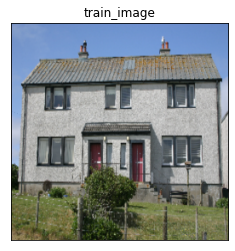

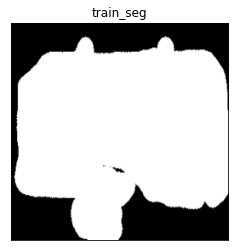

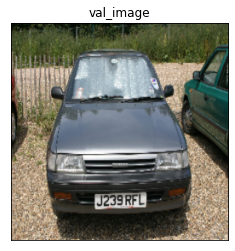

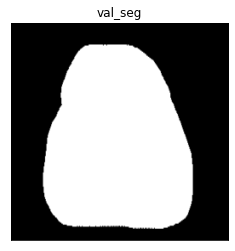

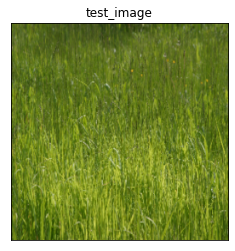

In [79]:
input,labels = next(iter(train_dataloader))
print(input.shape,labels.shape)
print(type(input[2]))
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
print(mask.shape)
plot_image(img * 0.5 + 0.5, 'train_image', cv2=False)
plot_image(mask, 'train_seg')

input,labels = next(iter(val_dataloader))
print(input.shape,labels.shape)
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'val_image', cv2=False)
plot_image(mask, 'val_seg')

input = next(iter(test_dataloader))
print(input.shape)
img = input[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'test_image', cv2=False)

## 1. Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to perform these segmentations, where we need to distinguish foreground from background, where the class of interest is considered foreground.

###  U-Net

<img src="https://www.researchgate.net/profile/Alan-Jackson-2/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png" style="width:650px;height:400px;">

A U-Net is an end-to-end segmentation network that should work reasonably well in this low data setting. It will take an image, progressively convolve it to a collection of many small feature maps, and then progressively up-convolve the maps while combining with crops from the previous layers. The figure provided gives an excellent example of a baseline U-Net that you can use as a starting point.

For these operations, use ```nn.Conv2d```, ```torch.cat```, and ```nn.ConvTranspose2d```, ```nn.MaxPool2d```. You may find it useful to use ```nn.BatchNorm2d``` as well.

Note that you can experiment with different channel sizes. Try to start with something smaller than 112, like 16.

Let's now implement those the model!

In [80]:
def double_conv(in_c, out_c):
  conv = nn.Sequential(
          nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(out_c),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(out_c),
          nn.ReLU(inplace=True)
  )
  return conv

In [81]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.down_conv_1 = double_conv(3,112)
    self.down_conv_2 = double_conv(112, 224)
    self.down_conv_3 = double_conv(224, 448)
    self.down_conv_4 = double_conv(448, 448)

    self.up_trans_1 = nn.ConvTranspose2d(in_channels=448, out_channels=448, 
                                        kernel_size=2, stride=2)
    self.up_conv_1 = double_conv(896, 224)

    self.up_trans_2 = nn.ConvTranspose2d(in_channels=224, out_channels=224, 
                                        kernel_size=2, stride=2)
    self.up_conv_2 = double_conv(448, 112)

    self.up_trans_3 = nn.ConvTranspose2d(in_channels=112, out_channels=112, 
                                        kernel_size=2, stride=2)
    self.up_conv_3 = double_conv(224, 112)

    self.dropout = nn.Dropout2d(p=0.2)

    self.conv_1x1 = nn.Sequential(
                    nn.Conv2d(in_channels=112, out_channels=1, kernel_size=1),
                    nn.BatchNorm2d(1),
                    nn.Sigmoid()
                    )


  def forward(self, input):
    #encoder
    x1 = self.down_conv_1(input)
    x2 = self.max_pool_2x2(x1)
    x3 = self.down_conv_2(x2)
    x4 = self.max_pool_2x2(x3)
    x5 = self.down_conv_3(x4)
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv_4(x6)
    
    #decoder
    x = self.up_trans_1(x7)
    x = torch.cat([x,x5], 1)
    x = self.dropout(x)
    x = self.up_conv_1(x)

    x = self.up_trans_2(x)
    x = torch.cat([x,x3], 1)
    x = self.dropout(x)
    x = self.up_conv_2(x)

    x = self.up_trans_3(x)
    x = torch.cat([x,x1], 1)
    x = self.dropout(x)
    x = self.up_conv_3(x)
    
    mask = self.conv_1x1(x)

    return mask

    


## 2. Defining the for loop for train and validation phase

### In each the phases certain things one has to be careful of:

- Training Phase:
  - Make sure the model is in train mode. That is ensured by `model.train()`

  - While looping over instances of a batch, make sure the graidents are always set to zero before calling the backward function. That's done by `optim.zero_grad()`. If this is not done, the gradients get accumulated.

  - Call the backward function on the loss by `loss.backward()` so that the loss get back propagated.

  - Call the step function of the optimiser to update the weights of the network. This is done by `optim.step()`

- Validation/Testing Phase
  - Make sure your model is in eval mode. This makes the model deterministic rather than probabilistic. This is ensured by `model.eval()`
  - As we don't need any gradients doing our validation/ testing phase, we can esnure that they are not calculated by defining a block with `torch.no_grad()`

In [82]:
def pixelAcc(target, predicted):    
    if target.shape != predicted.shape:
        print("target has shape", target.shape, ", predicted has shape", predicted.shape)
        return
        
    target = torch.round(target)
    predicted = torch.round(predicted)

    accsum=0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu()
        
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu()
        same = torch.eq(target_arr, predicted_arr).sum()
        total = torch.numel(target_arr)

        accsum += same/total
    
    pixelAccuracy = accsum/target.shape[0]        
    return pixelAccuracy*100

In [83]:
torch.manual_seed(1)
model = UNet()
model = model.cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# lambda1 = lambda epoch: 0.95
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda1)

# Containers for plot against no. of iterations
iters = []                                                                      # iterations 1,2,3, ...
train_loss_iter = []                                                            # collects training loss for each iteration
val_loss_iter = []                                                              # collects validation loss for each iteration
train_acc_iter = []                                                             # likewise
val_acc_iter = []

# Containers for plot against no. of epochs
epochs = []                                                                     # epochs 1,2,3, ...
train_loss_epoch = []                                                           # collects training loss for each epoch
val_loss_epoch = []                                                             # collects validation loss for each epoch
train_acc_epoch = []                                                            # likewise
val_acc_epoch = []

# Run your training / validation loops
n = 0                                                                           # iteration counter

for epoch in range(num_epochs):
  
  
  train_loss = []                                                               # these containers collect data for every batch in the epoch and
  val_loss = []                                                                 # reset at every new epoch
  train_acc = []                                                                # these containers are not used for plotting, only to calculate mean of the data collected over the epoch
  val_acc = []
 
  #-----------------------------------------------------------------------------
  # Training loop
  #-----------------------------------------------------------------------------
  model.train()

  for images,true_masks in iter(train_dataloader):

    iters.append(n)                                                             # append to iters axis


    images,true_masks = images.cuda(), true_masks.cuda()                        # converting datatype to cuda format
    masks_pred = model(images)                                                  # run model, obtain predicted mask

    # training loss
    loss = criterion(masks_pred, true_masks)                                    # loss for the batch/iteration

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    

    train_loss.append(float(loss)/16)                                           # the epoch's data (to be averaged later)
    train_loss_iter.append(float(loss)/16)                                      # for iterations plot                                 

    # training accuracy
    acc_iter = pixelAcc(true_masks, masks_pred)                                 # accuracy for the batch/iteration

    train_acc.append(acc_iter)                                                  # the epoch's data (to be averaged later)
    train_acc_iter.append(acc_iter)                                             # for iterations plot    

    #---------------------------------------------------------------------------
    # Validation loop - runs after every training batch
    #---------------------------------------------------------------------------
    if n%5 == 0:
      val_losses_iter = []                                                        # collects loss for every batch in validation dataset                  
      val_accs_iter = []                                                          # collects accuracy for the same
      
      with torch.no_grad():
        model.eval()
        
        # For every batch in validation dataset
        for images,true_masks in iter(val_dataloader):

          images,true_masks = images.cuda(), true_masks.cuda()

          masks_pred = model(images)
          loss = criterion(masks_pred, true_masks)
          val_losses_iter.append(float(loss)/16)

          #accuracy
          acc_iter = pixelAcc(true_masks, masks_pred)
          val_accs_iter.append(acc_iter)

      val_loss.append(np.mean(val_losses_iter))                                   # averaging to find metric for the nth (training)iteration
      val_loss_iter.append(np.mean(val_losses_iter))                              # for iterations plot

      val_acc.append(np.mean(val_accs_iter))
      val_acc_iter.append(np.mean(val_accs_iter))                                 # for iterations plot

    n+= 1                                                                       # increment iteration counter   

  scheduler.step()                                                              # LR scheduler

  epochs.append(epoch)                                                          # append to epochs axis

  train_loss_epoch.append(np.mean(train_loss))                                  # the epoch's data, averaged
  train_acc_epoch.append(np.mean(train_acc))
  val_loss_epoch.append(np.mean(val_loss))
  val_acc_epoch.append(np.mean(val_acc))

  # print epoch metrics
  # if epoch%100==0:                                                            
  print("Epoch : {}, Train loss: {} , Train Acc: {}, Val loss: {}, Val acc: {}".format(epoch, np.mean(train_loss), np.mean(train_acc), np.mean(val_loss), np.mean(val_acc)))
    

Epoch : 0, Train loss: 3.652834219946748 , Train Acc: 39.08278274536133, Val loss: 2.6311413447062173, Val acc: 57.923126220703125
Epoch : 1, Train loss: 0.6414345635899475 , Train Acc: 53.663841247558594, Val loss: 0.7103074435144663, Val acc: 49.692440032958984
Epoch : 2, Train loss: 0.047127996172223775 , Train Acc: 57.87629699707031, Val loss: 0.045484014165898166, Val acc: 43.998043060302734
Epoch : 3, Train loss: 0.04023702371688116 , Train Acc: 60.808685302734375, Val loss: 0.04598239343613386, Val acc: 43.34490203857422
Epoch : 4, Train loss: 0.037123183852859905 , Train Acc: 65.44486236572266, Val loss: 0.04578584339469671, Val acc: 54.700225830078125
Epoch : 5, Train loss: 0.03550127423590138 , Train Acc: 67.51981353759766, Val loss: 0.043317507952451706, Val acc: 63.2779541015625
Epoch : 6, Train loss: 0.03590336965308303 , Train Acc: 70.10128784179688, Val loss: 0.040432674499849476, Val acc: 66.70458984375
Epoch : 7, Train loss: 0.035222891185964854 , Train Acc: 70.1368026

## 3. Challenge Submission
Evaluate on the test set, and save the resulting segmentations in the same format as those in the initial dataset. 
Your challenge results should be saved in a torch file with the same format as in A3, with shape (24, 256, 256), where all values are either 1 (foreground) or 0 (background).

In [85]:
def generate_results_file(masks_pred,nick_name):
        save_path = 'challenge_4_{}.pth.tar'.format(nick_name)
        torch.save(masks_pred, save_path)

In [91]:
nick_name = 'ereh' # unique nick name!

model.eval()
for images in iter(test_dataloader):
  with torch.no_grad(): 
    images= images.cuda()

    masks_pred = model(images)

    masks_pred_before_squeeze = torch.round(masks_pred)
    masks_pred = torch.squeeze(masks_pred_before_squeeze)
    
generate_results_file(masks_pred,nick_name)

Use this code to check your submission file:

In [87]:
masks = torch.load('challenge_4_{}.pth.tar'.format(nick_name))

assert(masks.shape == (24, 256, 256))
assert((torch.where(masks == 1, 10, 0).sum() + torch.where(masks == 0, 10, 0).sum()).item() == 24 * 256 * 256 * 10)

## Analysis



### 4. Plot training and validation loss per batch

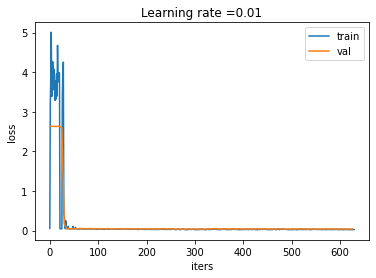

In [88]:
plt.plot(iters, train_loss_iter)
plt.plot(iters[::5], val_loss_iter)
plt.ylabel('loss')
plt.xlabel('iters')
plt.title("Learning rate =" + str(learning_rate))
plt.legend(["train", "val"])
plt.show()

### 5. Plot training and validation per-pixel accuracy per epoch

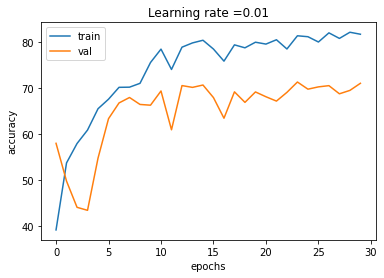

In [89]:
plt.plot( epochs, train_acc_epoch)
plt.plot( epochs, val_acc_epoch)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.title("Learning rate =" + str(learning_rate))
plt.legend(["train", "val"])
plt.show()

### 6. Show segmentation result for 3 test images



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


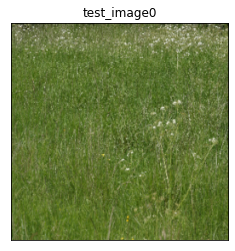

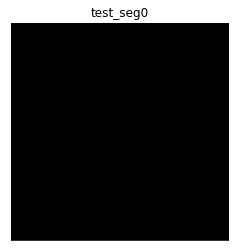

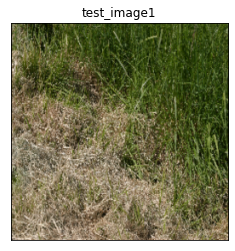

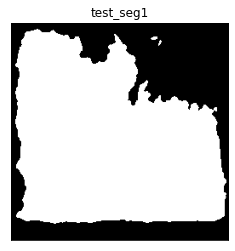

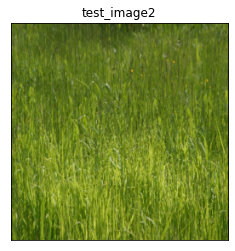

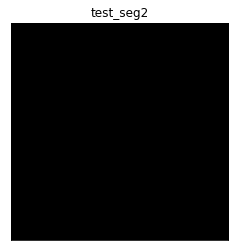

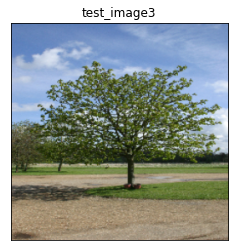

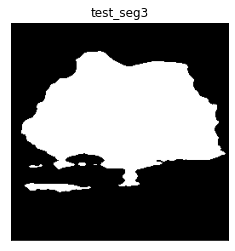

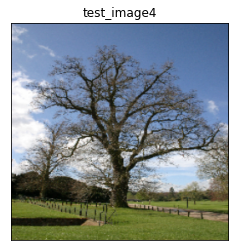

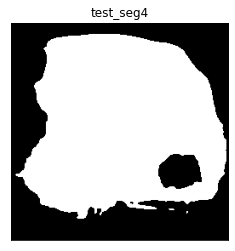

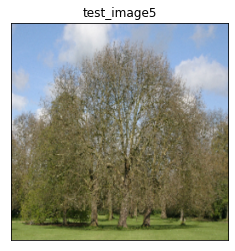

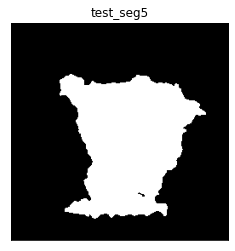

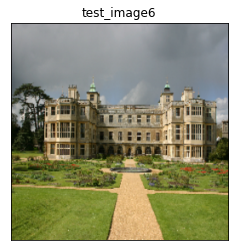

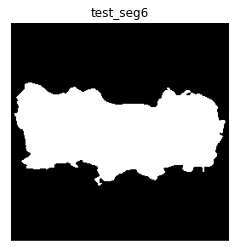

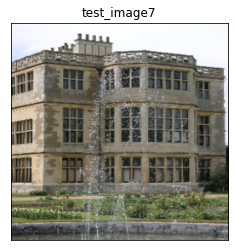

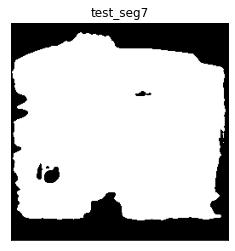

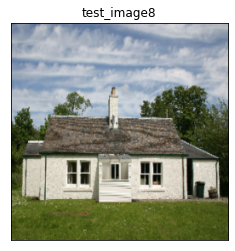

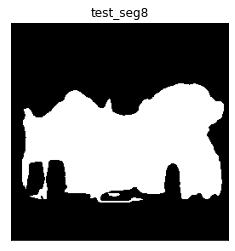

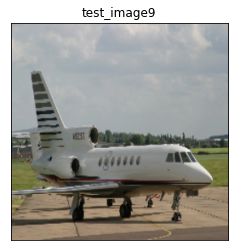

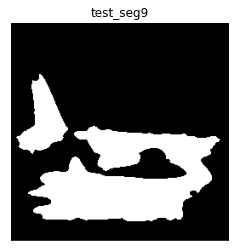

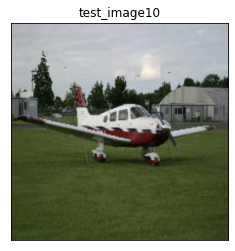

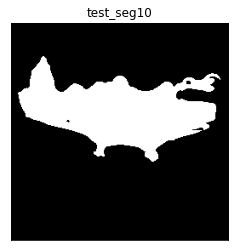

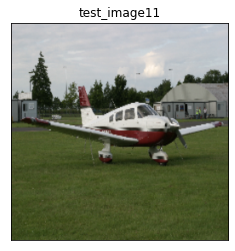

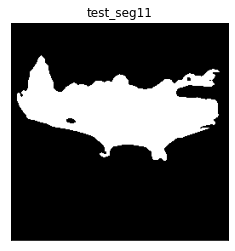

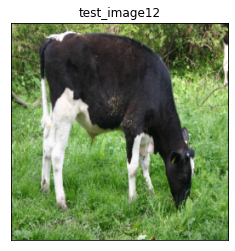

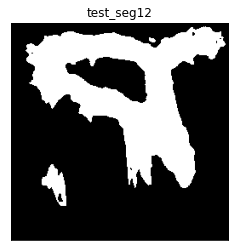

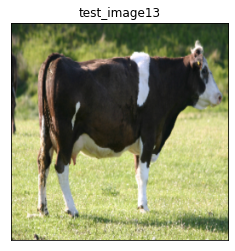

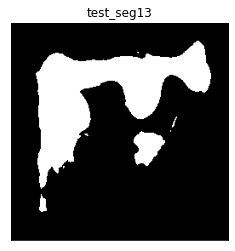

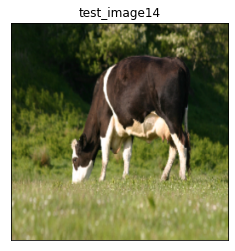

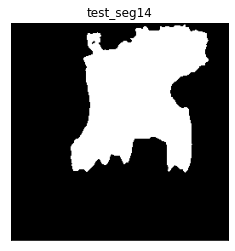

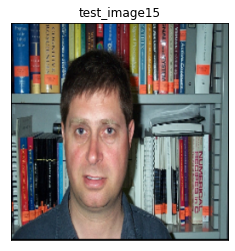

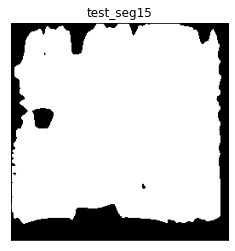

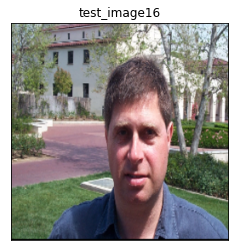

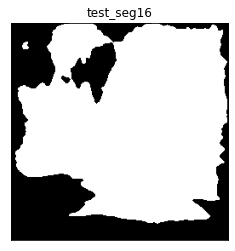

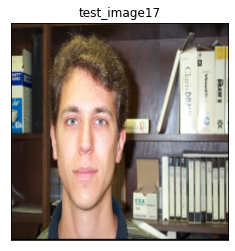

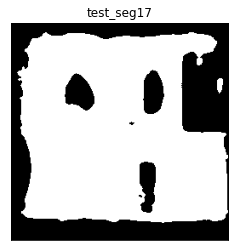

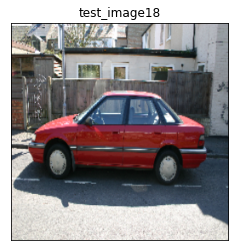

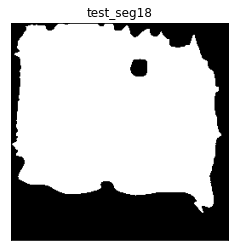

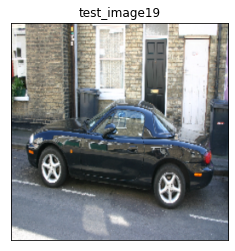

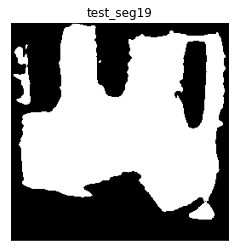

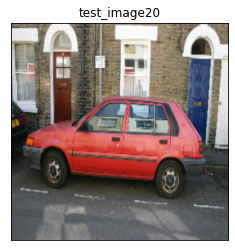

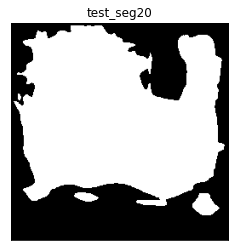

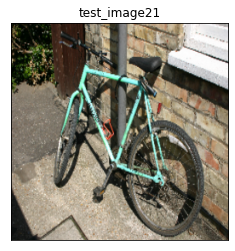

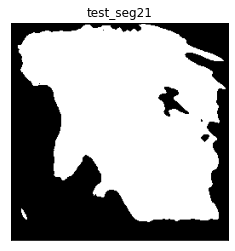

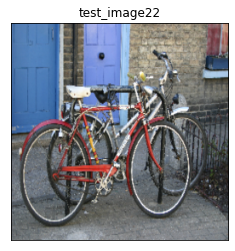

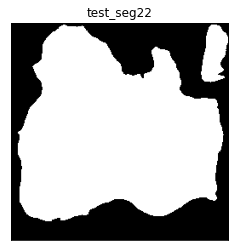

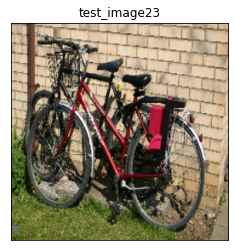

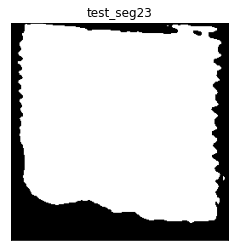

In [90]:
for k in range(batch_size_test):

  img = images[k].cpu().numpy().transpose(1, 2, 0)
  plot_image(img * 0.5 + 0.5, 'test_image{}'.format(k), cv2=False)

  mask = masks_pred_before_squeeze[k].cpu().numpy().transpose(1, 2, 0)
  plot_image(mask, 'test_seg{}'.format(k))

